In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer

!pip install livelossplot
print(torchbearer.__version__)

0.5.3


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
import tensorflow.keras.backend as K


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKerasTF
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier


from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.11.0


In [3]:
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 200
LOSS_FUNCTION = 'squared_hinge'
LEARNING_RATE = 0.002
IMAGE_SIZE = 48

In [4]:
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.15
HEIGHT_SHIFT_RANGE = 0.15
SHEAR_RANGE = 0.15
ZOOM_RANGE = 0.15

In [5]:
train_data = pd.read_csv('../input/fer2013/train_csv.csv')
#check data shape
train_data.shape

(59876, 2)

In [6]:
train_data.head(5)

,pixels,label
0,147 143 143 141 139 139 142 148 153 150 146 14...,3
1,191 191 191 151 138 135 120 113 119 117 114 10...,4
2,121 114 103 103 93 82 78 80 85 80 75 73 69 66 ...,2
3,83 76 81 121 153 163 169 174 182 188 189 192 1...,5
4,150 150 152 152 154 158 162 159 170 112 0 0 6 ...,5


In [7]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
emotion_counts = train_data['label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['label', 'number']
emotion_counts['label'] = emotion_counts['label'].map(emotion_map)
emotion_counts

,label,number
0,Happy,8223
1,Neutral,8965
2,Fear,8097
3,Sad,8830
4,Digust,8284
5,Angry,7966
6,Surprise,9511


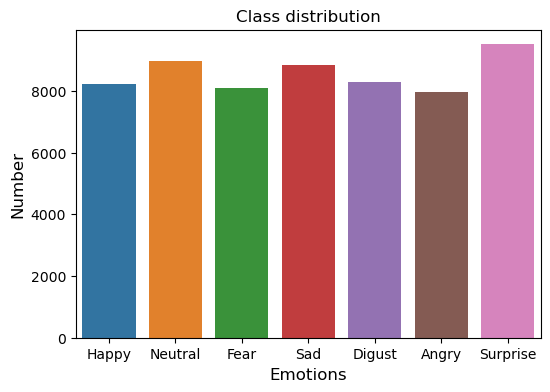

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x = emotion_counts.label, y = emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [9]:
def get_data(df):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,IMAGE_SIZE, IMAGE_SIZE,1)/255.0   
    data_Y = to_categorical(df['label'], NUM_CLASSES)
    print("Data X Shape: ", data_X.shape, ", Data Y Shape: ", data_Y.shape ) 
    return data_X, data_Y

In [10]:
X, Y = get_data(train_data)

Data X Shape:  (59876, 48, 48, 1) , Data Y Shape:  (59876, 7)


In [11]:
emotions = ['Angry','Digust','Fear','Happy','Neutral','Sad','Surprise']

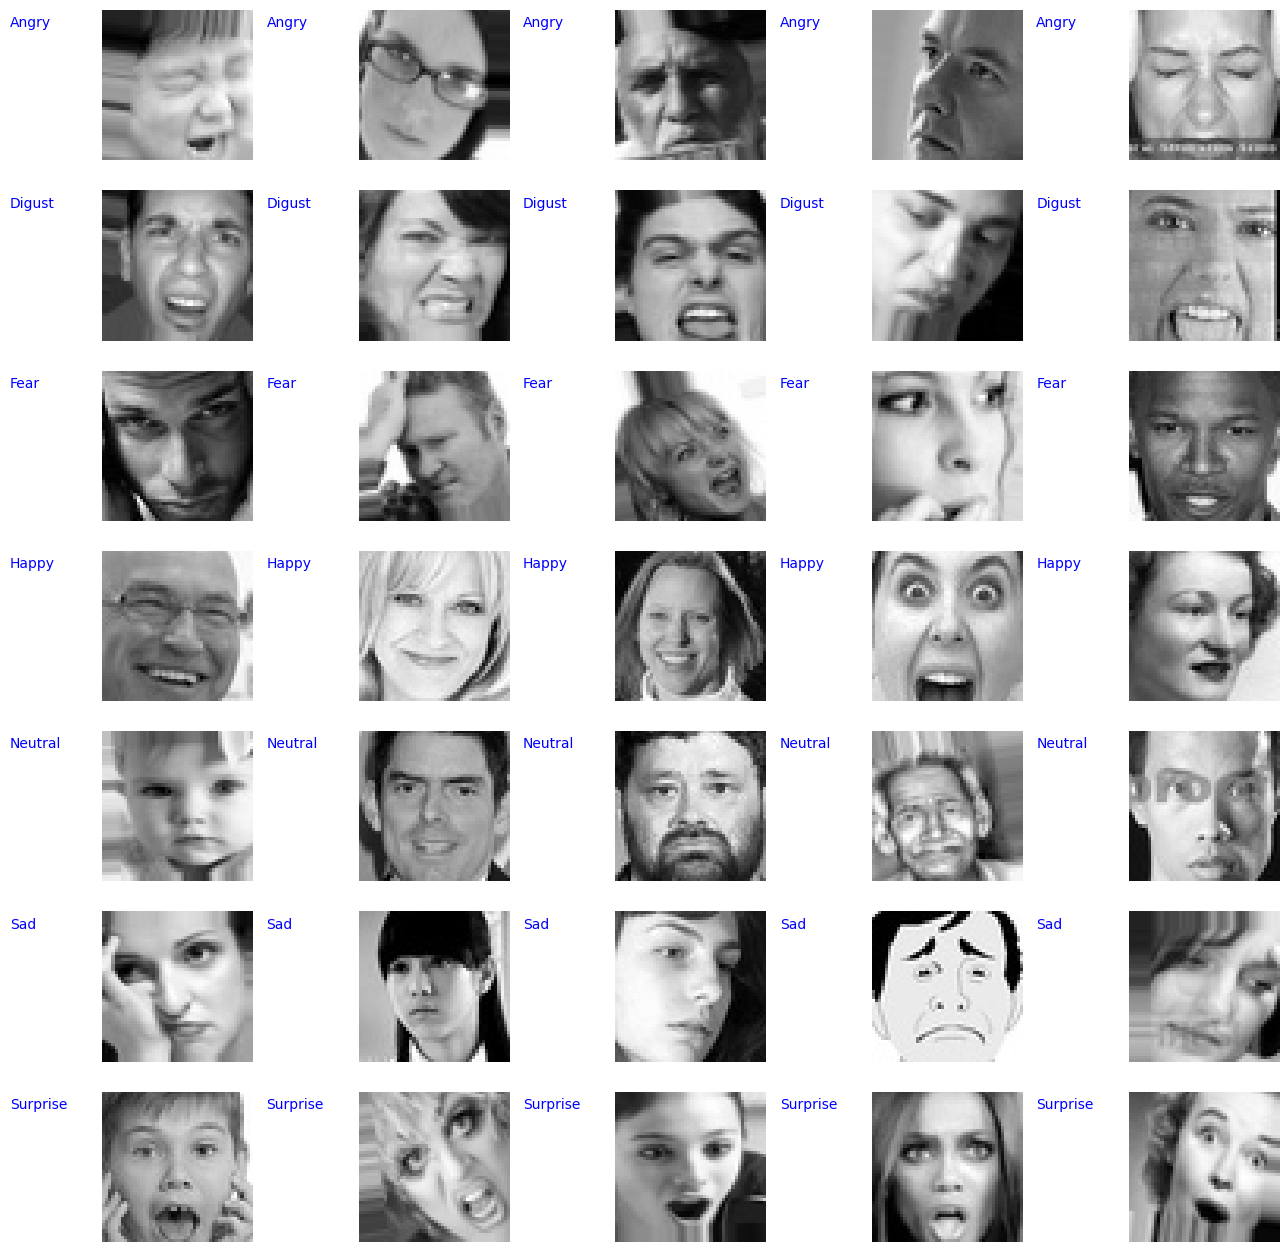

In [12]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(train_data['label'].values):

    all_emotion_images = train_data[train_data['label'] == emotion]
    for i in range(5):
        
        img = np.array(all_emotion_images.iloc[i,].pixels).reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()

In [13]:
test_data = pd.read_csv('../input/fer2013test/test_csv.csv')
#check data shape
test_data.shape

(7178, 2)

In [14]:
emotion_counts = test_data['label'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['label', 'number']
emotion_counts['label'] = emotion_counts['label'].map(emotion_map)
emotion_counts

,label,number
0,Angry,958
1,Surprise,831
2,Neutral,1233
3,Sad,1247
4,Fear,1024
5,Happy,1774
6,Digust,111


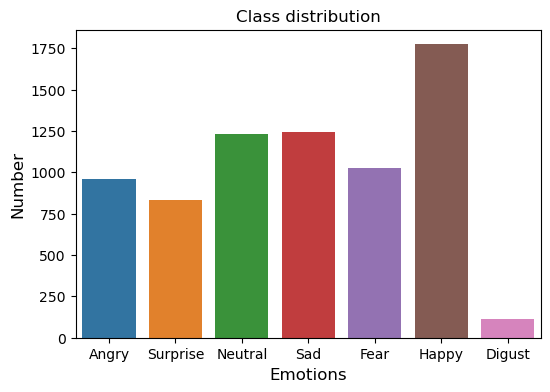

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(x = emotion_counts.label, y = emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [16]:
x,y = shuffle(X,Y, random_state=2)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    x, y, test_size = 0.3, stratify = y, random_state = 2
)

In [18]:
X_test, Y_test = get_data(test_data)

Data X Shape:  (7178, 48, 48, 1) , Data Y Shape:  (7178, 7)


In [19]:
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)
print()
print('X_test Shape:', X_test.shape)
print('Y_test Shape:', Y_test.shape)

X_train Shape: (41913, 48, 48, 1)
y_train Shape: (41913, 7)

X_valid Shape: (17963, 48, 48, 1)
y_valid Shape: (17963, 7)

X_test Shape: (7178, 48, 48, 1)
Y_test Shape: (7178, 7)


In [20]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
def create_model():
    model_1 = Sequential()

    model_1.add(Conv2D(64, (5, 5), padding='same', input_shape=(48, 48,1),kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(64, (5, 5), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.2))

    model_1.add(Conv2D(128, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(128, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.2))

    model_1.add(Conv2D(256, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(256, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.2))

    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.2))
    
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Conv2D(512, (3, 3), padding='same',kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model_1.add(Dropout(0.2))

    model_1.add(Flatten())
    model_1.add(Dropout(0.2))


    model_1.add(Dense(256,kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Dropout(0.2))

    model_1.add(Dense(128,kernel_initializer = 'he_normal'))
    model_1.add(BatchNormalization())
    model_1.add(Activation('relu'))
    model_1.add(Dropout(0.2))

    model_1.add(Dense(64,kernel_initializer = 'he_normal'))
    model_1.add(Activation('relu'))
    model_1.add(BatchNormalization())
    model_1.add(Dropout(0.2))

    model_1.add(Dense(NUM_CLASSES, kernel_regularizer = L2(0.01), activation='softmax'))
    
    model_1.compile(loss=LOSS_FUNCTION, optimizer = Adam(LEARNING_RATE), metrics=['accuracy',
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,])
    
    return model_1

In [22]:
model_1 = create_model()
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0

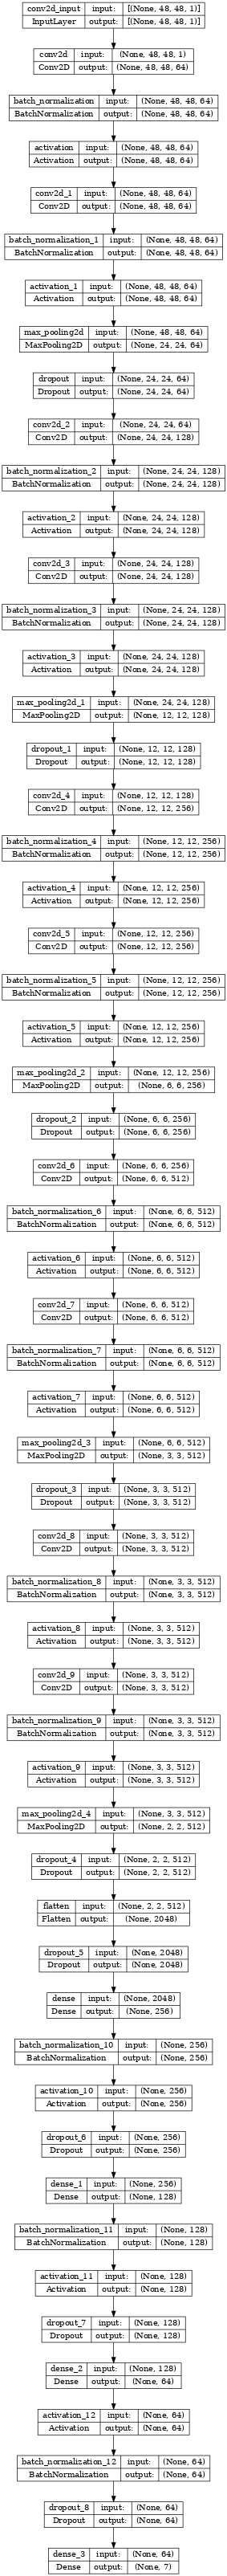

In [23]:
plot_model(model_1,
           show_shapes=True, 
           show_layer_names=True, 
           expand_nested=True, 
           dpi=50,
           to_file='CNN_SVM_V2.png')

In [24]:
file_path = "../working/CNN_SVM_V2.hdf5"
# Callback to save Model
checkpoint = ModelCheckpoint(
    file_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback to early stopping of Training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode="max",
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# Callback to reduce Learning Rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode="max",
    factor=0.5,
    patience=7,
    min_lr=1e-8,
    verbose=1,
)

model_callbacks = [
    PlotLossesKerasTF(),
    early_stopping,
    lr_scheduler,
    checkpoint,
]

In [25]:
train_data_generator = ImageDataGenerator(
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range = ROTATION_RANGE,
                            width_shift_range = WIDTH_SHIFT_RANGE,
                            height_shift_range = HEIGHT_SHIFT_RANGE,
                            shear_range = SHEAR_RANGE,
                            zoom_range = ZOOM_RANGE,
                            fill_mode='nearest',
                            horizontal_flip = True)

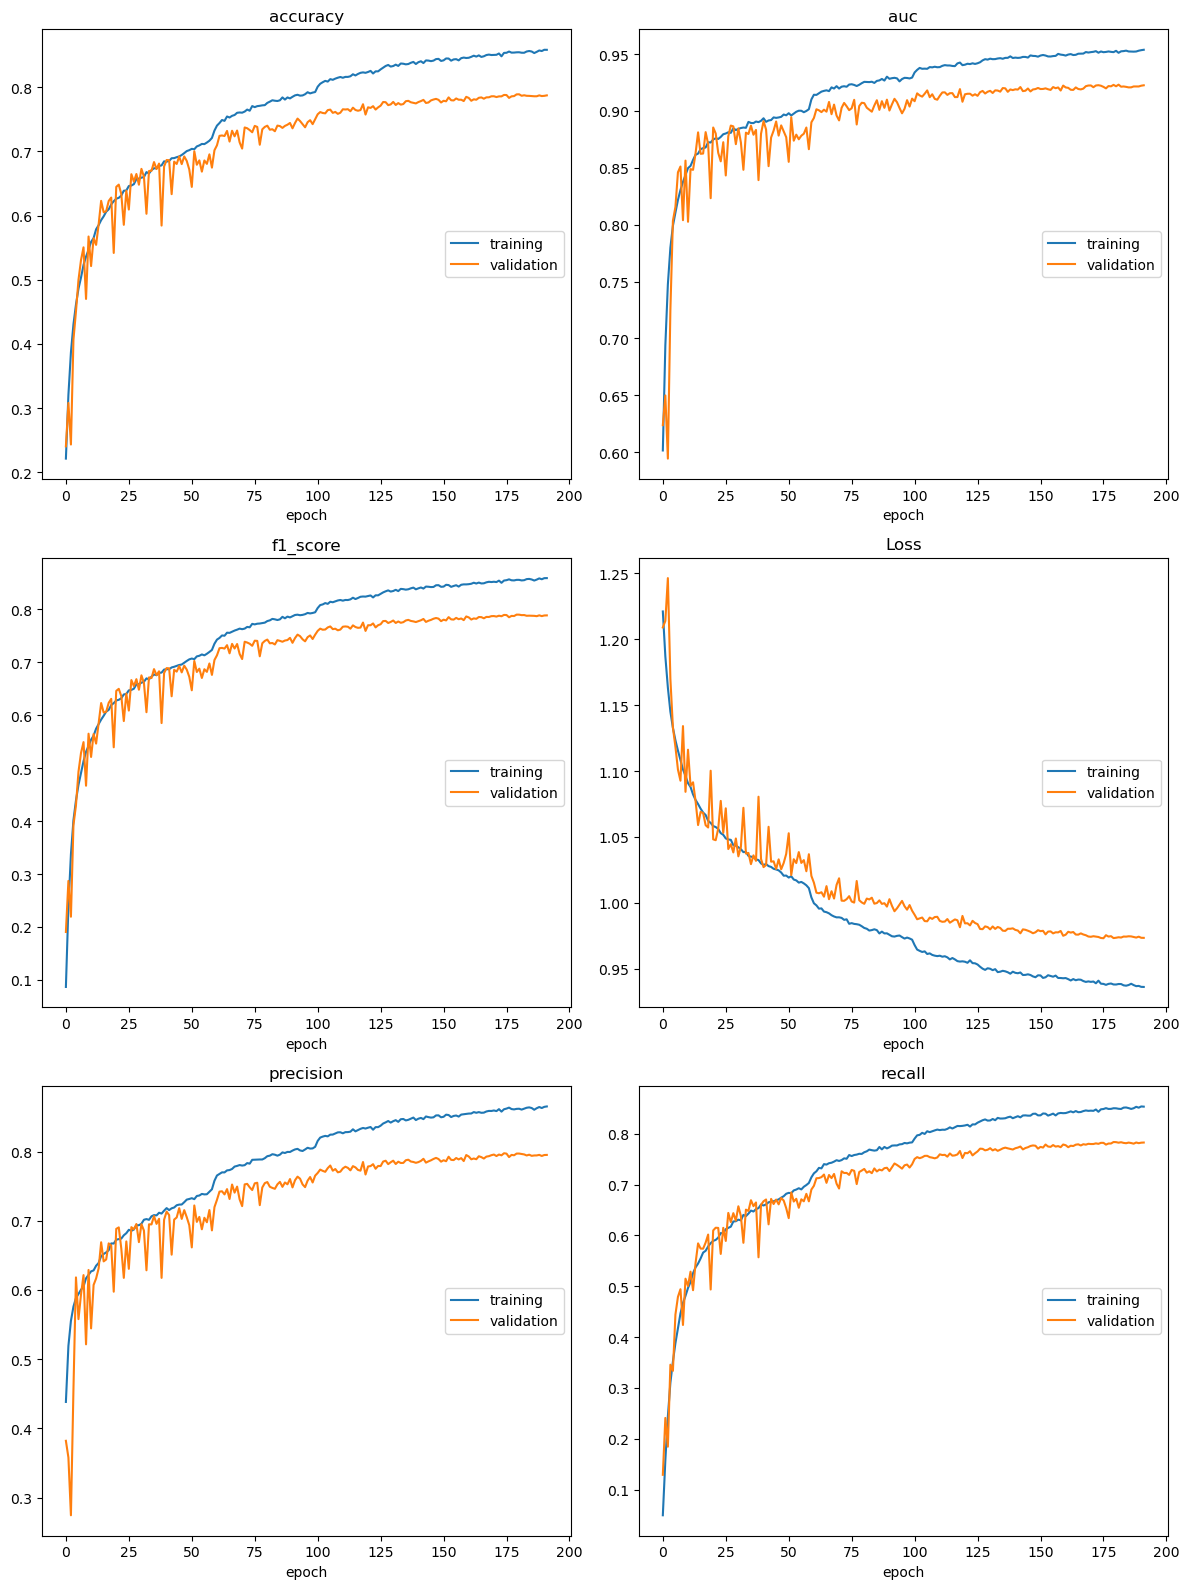

accuracy
	training         	 (min:    0.221, max:    0.858, cur:    0.858)
	validation       	 (min:    0.241, max:    0.789, cur:    0.787)
auc
	training         	 (min:    0.601, max:    0.954, cur:    0.954)
	validation       	 (min:    0.594, max:    0.923, cur:    0.923)
f1_score
	training         	 (min:    0.087, max:    0.859, cur:    0.859)
	validation       	 (min:    0.190, max:    0.790, cur:    0.789)
Loss
	training         	 (min:    0.936, max:    1.221, cur:    0.936)
	validation       	 (min:    0.973, max:    1.246, cur:    0.974)
precision
	training         	 (min:    0.438, max:    0.865, cur:    0.865)
	validation       	 (min:    0.274, max:    0.798, cur:    0.795)
recall
	training         	 (min:    0.049, max:    0.854, cur:    0.853)
	validation       	 (min:    0.129, max:    0.784, cur:    0.783)
Restoring model weights from the end of the best epoch: 181.

Epoch 192: val_accuracy did not improve from 0.78890
Epoch 192: early stopping


In [26]:
history_1 = model_1.fit(
        train_data_generator.flow(X_train, y_train, BATCH_SIZE),
        steps_per_epoch=len(X_train) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_valid, y_valid),
        callbacks=model_callbacks,
        verbose=0)

In [27]:
model_1.load_weights('../working/CNN_SVM_V2.hdf5')

In [28]:
# def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
#     fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
#     fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

#     ax1.plot(range(1, len(acc) + 1), acc)
#     ax1.plot(range(1, len(val_acc) + 1), val_acc)
#     ax1.set_title('History of Accuracy')
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Accuracy')
#     ax1.legend(['training', 'validation'])


#     ax2.plot(range(1, len(loss) + 1), loss)
#     ax2.plot(range(1, len(val_loss) + 1), val_loss)
#     ax2.set_title('History of Loss')
#     ax2.set_xlabel('Epochs')
#     ax2.set_ylabel('Loss')
#     ax2.legend(['training', 'validation'])
    
#     ax3.plot(range(1, len(auc) + 1), auc)
#     ax3.plot(range(1, len(val_auc) + 1), val_auc)
#     ax3.set_title('History of AUC')
#     ax3.set_xlabel('Epochs')
#     ax3.set_ylabel('AUC')
#     ax3.legend(['training', 'validation'])
    
#     ax4.plot(range(1, len(precision) + 1), precision)
#     ax4.plot(range(1, len(val_precision) + 1), val_precision)
#     ax4.set_title('History of Precision')
#     ax4.set_xlabel('Epochs')
#     ax4.set_ylabel('Precision')
#     ax4.legend(['training', 'validation'])

#     ax5.plot(range(1, len(f1) + 1), f1)
#     ax5.plot(range(1, len(val_f1) + 1), val_f1)
#     ax5.set_title('History of F1-score')
#     ax5.set_xlabel('Epochs')
#     ax5.set_ylabel('F1 score')
#     ax5.legend(['training', 'validation'])


#     plt.show()
    

# Train_Val_Plot(history_1.history['accuracy'],history_1.history['val_accuracy'],
#                history_1.history['loss'],history_1.history['val_loss'],
#                history_1.history['auc'],history_1.history['val_auc'],
#                history_1.history['precision'],history_1.history['val_precision'],
#                history_1.history['f1_score'],history_1.history['val_f1_score']
#               )
              

In [29]:
score = model_1.evaluate(X_test, Y_test, verbose=0, batch_size=BATCH_SIZE)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test auc:', score[4])
print('Test f1_score:', score[5])

Test Loss: 1.031067132949829
Test accuracy: 0.6823627948760986
Test precision: 0.6928561329841614
Test recall: 0.6769295334815979
Test auc: 0.8690298795700073
Test f1_score: 0.6851851940155029


In [30]:
from sklearn.metrics import confusion_matrix
t_predict_x=model_1.predict(x) 
results=np.argmax(t_predict_x,axis=1)
# results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(y == 1)[1], results)

1872/1872 [==============================] - 15s 8ms/step


In [31]:
cm_df = pd.DataFrame(cm, index = emotions,
                     columns = emotions
                    )

final_cm = cm_df
final_cm

,Angry,Digust,Fear,Happy,Neutral,Sad,Surprise
Angry,6352,17,384,156,519,458,80
Digust,39,8161,31,12,11,29,1
Fear,381,15,6096,174,442,638,351
Happy,75,1,75,7702,223,74,73
Neutral,186,2,153,380,7813,397,34
Sad,349,7,404,151,739,7125,55
Surprise,71,23,349,252,119,78,8619


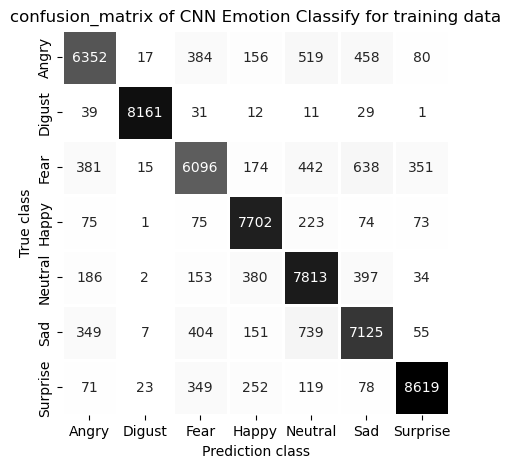

In [32]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('confusion_matrix of CNN Emotion Classify for training data')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [33]:
predict_x=model_1.predict(X_test) 
results=np.argmax(predict_x,axis=1)
# results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(Y_test == 1)[1], results)

225/225 [==============================] - 2s 7ms/step


In [34]:
cm_df = pd.DataFrame(cm, index = emotions,
                     columns = emotions
                    )

final_cm = cm_df
final_cm

,Angry,Digust,Fear,Happy,Neutral,Sad,Surprise
Angry,569,4,105,54,87,123,16
Digust,24,64,2,4,6,10,1
Fear,104,0,507,37,118,188,70
Happy,22,0,28,1606,70,26,22
Neutral,67,0,67,98,828,166,7
Sad,114,0,132,70,216,694,21
Surprise,24,1,91,48,22,15,630


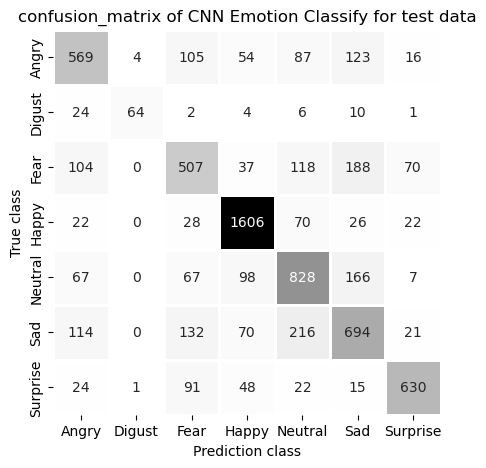

In [35]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('confusion_matrix of CNN Emotion Classify for test data')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [36]:
model_1.save('CNN_SVM_V2.h5')